## Experiments
In this section we provide the code for replicating the experiments from the paper.

### Simulation setup
We consider swarm of $n = 16$ drones initially distributed in a $4 \times 4$ grid formation. The function we are attemping to learn is the vertical component of the wind field in horizontal section of a cumulus formation. We simulate the cumulus based on the model provided in [<cite>  </cite>].

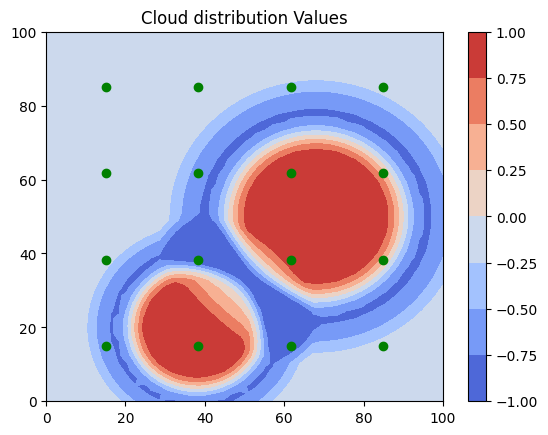

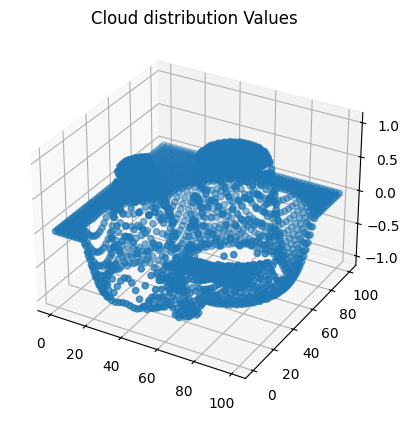

In [1]:
# GRID DRONE POSITION
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the simulation area (e.g., a 2D grid)
area_size = 100

# Number of drones for each row, column
num_dronesx = 4
num_dronesy = 4

# Total number of drones
num_drones = num_dronesx * num_dronesy

# Distance of the grid from the border
margin = 15 / 100 * area_size

# Create a 3D grid for x, y, and z
x = np.linspace(margin, area_size - margin, num_dronesx)
y = np.linspace(margin, area_size - margin, num_dronesy)

xv, yv = np.meshgrid(x, y)

# Initial positions of drones (x, y, z)
drone_positions = np.vstack([xv.ravel(), yv.ravel()]).T

def wind_field_2d(pos, clouds, t, winds_current):
    """
    Calculates the wind speed in the range [-1, 1] at the point (x, y)
    based on the distribution of clouds.

    Parameters:
    - x, y: 2D coordinates to evaluate the wind
    - clouds: list of clouds, each defined by (cx, cy, radius),
              where (cx, cy) is the center of the cloud and
              radius is the size of the cloud.
    - t: the time step I'm evaluating the function at.
    - winds_current: list describing the wind velocity that moves the clouds, made by [vx, vy]

    Returns:
    - wind: Vertical wind velocity at point (x, y) in the range [-1, 1].
    """

    # Initialize wind velocity
    x = pos[:,0]
    y = pos[:,1]
    # Iterate over each cloud
    for cloud in clouds:
        cx, cy, radius, height = cloud
        cx += winds_current[0]*t*0.03
        cy += winds_current[1]*t*0.03

        # Calculate horizontal distance from the cloud center
        horizontal_distance = np.sqrt((x - cx)**2 + (y - cy)**2)

        # 1. Updraft (center of the cloud) - strongest at the center and reduces outward
        wind_Updraft = np.where(horizontal_distance <= (radius*0.4) , np.exp(-(horizontal_distance**2) / (2 * radius**2)), 0)

        # 2. Downdraft (outflow at the cloud top)
        wind_Downdraft = np.where(np.logical_and(horizontal_distance > (radius*0.4), horizontal_distance <= (radius*0.7)) , np.exp(-(horizontal_distance**2) / (2 * radius**2)) * np.cos((horizontal_distance - (radius*0.4))*np.pi/(radius*0.3)), 0)

        # 2. Downdraft (outflow at the cloud top)
        wind_Downdraft += np.where(np.logical_and(horizontal_distance > (radius*0.7), horizontal_distance <= (radius)) , np.exp(-(horizontal_distance**2) / (2 * radius**2)) * (-1)* np.cos((horizontal_distance - (radius*0.7))*np.pi/(2*radius*0.3)), 0)

        # Sum up the wind contributions from all clouds
        try:
          wind += wind_Updraft + wind_Downdraft
        except:
          wind = wind_Updraft + wind_Downdraft
    # Clamp the wind velocity to be within the range [-1, 1]
    return np.clip(wind, -1, 1)

clouds_2d = [
    (50, 50, 40, 10),
    (20, 20, 30, 10),
]
wind_direction_clouds = np.array([1,0])

x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T

# Calculate the true function values
Z_true = wind_field_2d(XY, clouds_2d, 600, wind_direction_clouds).reshape(X.shape)

# Plot the true values
true_v = plt.contourf(X, Y, Z_true, cmap='coolwarm')
plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='green', label='Drones')
plt.colorbar(true_v)
plt.title('Cloud distribution Values')
plt.show()

# Plot the true values
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z_true)
# plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='green', label='Drones')
# plt.colorbar(true_v)
plt.title('Cloud distribution Values')
plt.show()



## Nystrom feature extractor
The class **model_E** implements the Nystrom approximation-based feature extractor.

In [2]:
# https://andrewcharlesjones.github.io/journal/nystrom-approximation.html ---theory

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

sigma_s      = 1
length_scale = 10

class model_E:
  def __init__(self, E, l, kernel=ConstantKernel(1e-2, constant_value_bounds="fixed") * RBF(length_scale, length_scale_bounds="fixed"), seed = 0):
    self.E = E
    self.l = l
    np.random.seed(seed)

    self.samples = np.random.rand(self.l,2) * area_size
    self.kernel = kernel
    K = self.kernel(self.samples)
    U, D, V = np.linalg.svd(K)
    self.Lambda = np.diag(D[:E])
    self.G = U[:,:E]

  def check(self):
      x = np.linspace(0, 1, 3)*area_size
      y = np.linspace(0, 1, 3)*area_size
      xy = np.vstack((x,y)).T
      m = x.shape[0]
      print(xy.shape)

      eigenfunctions = np.zeros((self.E, m))
      eigenfunctions = self.G.T @ self.kernel(self.samples, xy)

      diag = np.maximum(np.diag(self.Lambda), 1e-6)
      eigenvalues = self.Lambda

      K = eigenfunctions.T @ (eigenvalues) @ eigenfunctions
      print(K)

      try:
          np.linalg.cholesky(K)
          psd = True
          print("true")
      except np.linalg.LinAlgError:
          print("error")

  def __call__(self, t):
      #t must be a mx2 array
      m = t.shape[0]
      x = np.zeros((m,2))
      x = t
      Q, R = np.linalg.qr(self.G)
      self.G = Q
      eigenfunctions = np.zeros((self.E, m))
      eigenvalues = np.eye(self.E)
      eigenfunctions = self.G.T @ self.kernel(self.samples, x)
      diag = np.maximum(np.diag(self.Lambda), 1e-6)
      eigenvalues = np.diag(diag)

      return eigenfunctions, eigenvalues


## Baseline agent
In this section we define a BaselineAgent class that implements the time-varying distributed method from [<cite> D. Jang et. al </cite>].

In [3]:
class Baseline_Agent:
    def __init__(self, position, area_size, kernel, num_drones, E, l, sigma, length_scale, sigma2=1e-2, seed = 0):
        #position is a 2d coordinate
        self.position = position
        self.area_size = area_size
        self.kernel = kernel
        self.sigma2 = sigma2
        self.X_train = []
        self.y_train = []
        self.E = E
        self.l = l
        self.alpha = np.zeros((self.E, self.E))
        self.beta = np.zeros((self.E,1))
        self.model_e = model_E(self.E, l,kernel, seed)
        self.num_drones = num_drones
        self.map_f = wind_field_2d
        self.clouds = clouds_2d

    def move(self, step_size=1.0):
        iterate = True
        angle = np.random.uniform(0, 2 * np.pi)
        high = np.random.uniform(-1, 1)
        old_pos = [self.position[0], self.position[1]]
        self.position[0] += step_size * np.cos(angle)
        self.position[1] += step_size * np.sin(angle)
        self.position[0] = np.clip(self.position[0], 0, self.area_size)
        self.position[1] = np.clip(self.position[1], 0, self.area_size)


    def collect_data(self, t):
        X_new = self.position.reshape(1, -1).copy()
        y_new = self.map_f(X_new, self.clouds, t, wind_direction_clouds)
        self.X_train.append(X_new)
        self.y_train.append(y_new)
        return X_new, y_new

    def update_gp(self, x_train = None, y_train = None):
        if x_train is None and y_train is None:
          x_train = self.X_train
          y_train = self.y_train
        m = len(x_train)

        if m > 0:
            self.alpha = np.zeros((self.E, self.E))
            self.beta = np.zeros((self.E,1))
            # Vectorized computation of phi and lamb
            phi, lamb = self.model_e(np.vstack(x_train))
            phi_x = phi @ phi.T
            phi_x = (phi_x + phi_x.T) / 2

            self.alpha = phi_x / m
            self.beta = phi @ np.array(y_train) / m

    def moving_update(self, x_new, y_new, r = None):
      m = len(self.X_train)
      if m > 0:
        if r is None:
          r = (1/m)
        phi, lamb = self.model_e(x_new)
        phi_x = phi @ phi.T
        self.alpha = (1-r) * self.alpha + r * phi_x
        self.beta = (1-r) * self.beta + r * (phi.T * y_new.flatten()).reshape((self.E,1))

    def representative_points(self, x_sample):
      r = 35 #representative radius
      x = np.linspace(0, area_size, 6)
      y = np.linspace(0, area_size, 6)
      X, Y = np.meshgrid(x, y)
      XY = np.vstack([X.ravel(), Y.ravel()]).T
      # Compute distances from the sample point to each grid point
      distances = np.linalg.norm(XY - x_sample, axis=1)

      # Filter points outside the radius R
      filtered_points = XY[distances > r,:]
      v_pred = np.zeros((filtered_points.shape[0],1))
      v_pred += self.variance(filtered_points)
      v_pred = v_pred.reshape(v_pred.shape[0])

      v = 0.45
      repr_points = filtered_points[v_pred < v,:]
      y_pred = np.zeros((repr_points.shape[0],1))
      y_pred += self.predict(repr_points)
      n = 6
      n = np.min((n,y_pred.shape[0]))
      indices = np.argpartition(y_pred.flatten(), -n)[-n:]
      return repr_points[indices], y_pred[indices]

    def weights_f(self, x_sample, XY):
      def rbf(x1, x2 = None, l = 30/2):
        l = l
        if x2 is None:
          diff = x1
        else:
          sigma =1
          diff = x1-x2
        return np.exp(-diff**2/(2 * l**2))
    
      distance = 60

      v_pred = np.zeros((XY.shape[0],1))
      v_pred += drone.variance(XY)
      v_pred = v_pred.reshape(v_pred.shape[0])
      diff = (x_sample -XY)
      weights = (1 - rbf(np.linalg.norm(diff, axis = 1), l = distance/2)) * rbf(v_pred, l = 1/4)
      return weights

    def moving_update_new(self, x_new, y_new, r = None):
      m = len(self.X_train)
      if m > 0:
        if r is None:
          r = (1/m)
        phi, lamb = self.model_e(x_new)
        phi_x = phi @ phi.T
        x_repr, y_repr = self.representative_points(x_new)
        n = x_repr.shape[1]
        print(f"n: {n}")
        phi_n, lamb_n = self.model_e(x_repr)
        phi_x += phi_n @ phi_n.T
        phi_x = phi_x/(n+1)
        beta_add = phi.T * y_new.flatten() + np.sum(phi_n * y_repr.reshape(1, -1), axis = 1)
        beta_add =  beta_add /(n+1)
        self.alpha = (1-r) * self.alpha + r * phi_x
        self.beta = (1-r) * self.beta + r * beta_add.reshape((self.E,1))

    def moving_update_weighted(self, x_new, y_new, XY, r = None):
      m = len(self.X_train)
      if m > 0:
        if r is None:
          r = (1/m)
        phi, lamb = self.model_e(x_new)
        phi_x = phi @ phi.T
        weights = self.weights_f(x_new, XY)
        weight_d = np.diag(weights)
        norm_weight = np.linalg.norm(weights)
        weight_d = weight_d / norm_weight
        # Visualize the positions
        x = np.linspace(0, area_size, 50)
        y = np.linspace(0, area_size, 50)
        X, Y = np.meshgrid(x, y)
        contour = plt.contourf(X, Y, (weights/norm_weight).reshape(X.shape), cmap='viridis')
        plt.colorbar(contour)
        plt.title("weigths")
        plt.show()
        phi_n, lamb_n = self.model_e(XY)
        phi_x += phi_n @ weight_d @ phi_n.T
        phi_x = phi_x/(2)
        y_repr = np.zeros((XY.shape[0],1))
        y_repr += self.predict(XY)
        y_repr = y_repr.reshape(y_repr.shape[0])
        beta_add = phi.T * y_new.flatten() + np.sum(phi_n @ weight_d * y_repr.reshape(1, -1), axis = 1)
        beta_add =  beta_add /(2)
        self.alpha = (1-r) * self.alpha + r * phi_x
        self.beta = (1-r) * self.beta + r * beta_add.reshape((self.E,1))

    def predict(self, X):
      predict = np.zeros(X.shape[0])
      m = len(self.X_train)
      phi, lamb = self.model_e(X)
      predict = phi.T @ np.linalg.inv(self.alpha + (self.sigma2 / (m))  * np.linalg.inv(lamb)) @ self.beta
      return predict

    def variance(self, X):
      m = len(self.X_train)
      predict = np.zeros((X.shape[0],1))
      phi, lamb = self.model_e(X)
      predict[:,0] = np.diag(phi.T @ np.linalg.solve(lamb, phi) - phi.T @ np.linalg.solve(self.alpha + sigma_s**2/m * lamb, self.alpha @ np.linalg.solve(lamb, phi)))
      predict_norm  = np.linalg.norm(predict)
      return predict

# DistKP agent

Here we provide a more efficient and stable version of the Agent class from **01_introduction.ipynb**.

In [4]:
class DistKP_Agent:
    def __init__(self, position, area_size, kernel, E, seed = 0):
        self.position = position
        self.area_size = area_size
        self.kernel = kernel
        self.X_train = []
        self.y_train = []
        self.E = E
        self.map_f = wind_field_2d
        self.clouds = clouds_2d

        #Kalman filter parameters:
        self.theta = np.zeros((E,1))
        self.P = 1 * np.eye(E)
        self.sigma_w = 0.005
        self.Q = self.sigma_w * np.eye(E)
        self.sigma_s = 5

        np.random.seed(seed)
        #Nystrom Method
        self.points = np.random.rand(E, 2) * area_size

        # Compute the kernel matrix
        kernel_matrix = self.kernel(self.points, self.points)

        # Perform Singular Value Decomposition (SVD)
        U, S, Vt = np.linalg.svd(kernel_matrix)

        # Create the diagonal matrix of singular values
        Lambda_E = np.diag(S)
        self.U = U
        self.Lambda_E = Lambda_E

    def move(self, step_size=1.0):
        iterate = True
        angle = np.random.uniform(0, 2 * np.pi)
        high = np.random.uniform(-1, 1)
        old_pos = [self.position[0], self.position[1]]
        self.position[0] += step_size * np.cos(angle)
        self.position[1] += step_size * np.sin(angle)
        self.position[0] = np.clip(self.position[0], 0, self.area_size)
        self.position[1] = np.clip(self.position[1], 0, self.area_size)

    def kalman_update(self, x, y):
      x_hat = self.theta
      P_hat = self.P + self.Q
      H = self.kernel(np.array([[x[0][0], x[0][1]]]), self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))
      R = sigma_s**2 * np.eye(H.shape[0])
      K = P_hat @ H.T @ np.linalg.inv(H @ P_hat @ H.T + R)
      self.theta = x_hat + K @ (y[0] - H @ x_hat)
      self.P = (np.eye(len(self.theta)) - K @ H) @ P_hat

    def collect_data(self, t):
        X_new = self.position.reshape(1, -1).copy()
        y_new = self.map_f(X_new, self.clouds, t, wind_direction_clouds)
        self.X_train.append(X_new)
        self.y_train.append(y_new)
        return X_new, y_new

    def predict(self, X):
      phi = self.kernel(X, self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))
      mu = phi @ self.theta
      return mu

    def variance(self, X):
      phi = self.kernel(X, self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))
      sigma_squared = phi @ self.P @ phi.T
      return np.diag(sigma_squared)



## Evolution of the mean and variance esimate
We compare DistKP and the baseline method from [<cite> D. Jang et. al </cite>]. Both methods are distributed and we plot the estimate of drone 6 (all of the 16 drones follow the same trajectories in both simulations).

### DistKP

/tmp/ipykernel_14598/962280199.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('coolwarm')


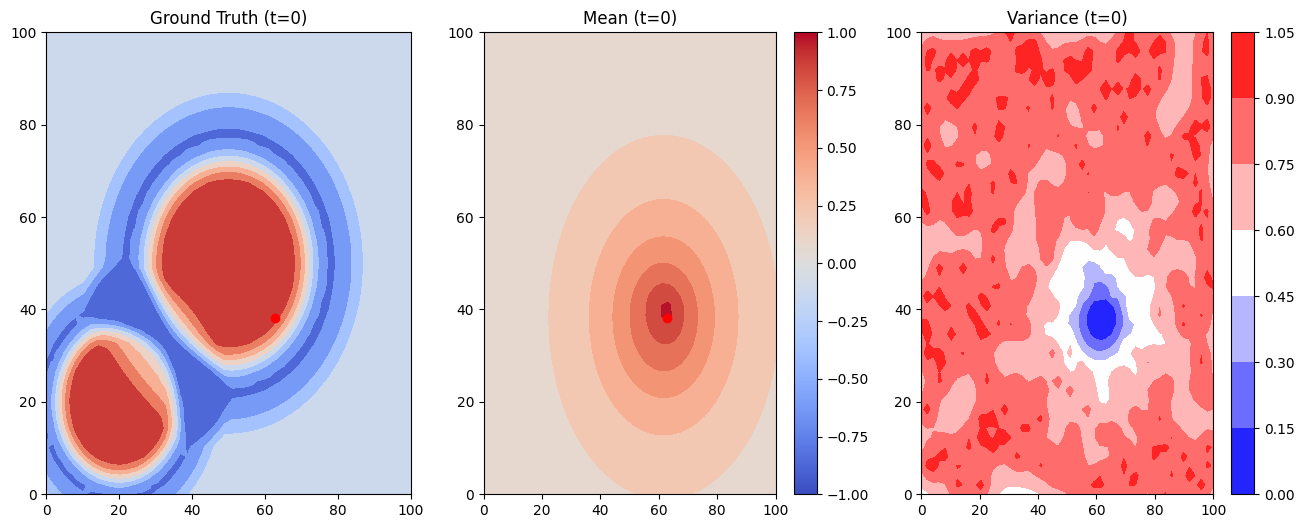

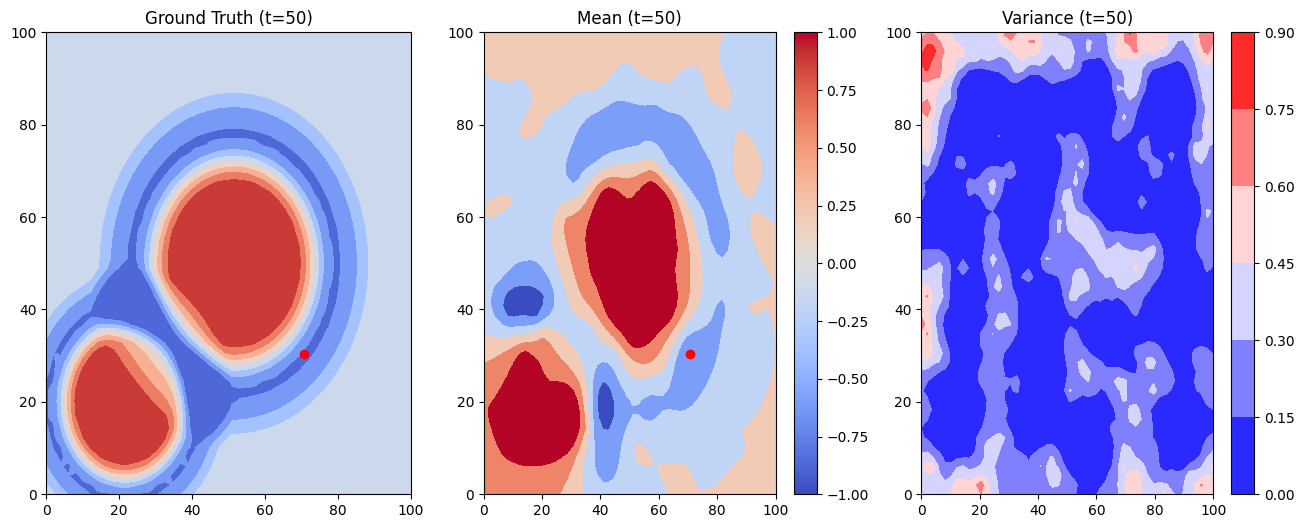

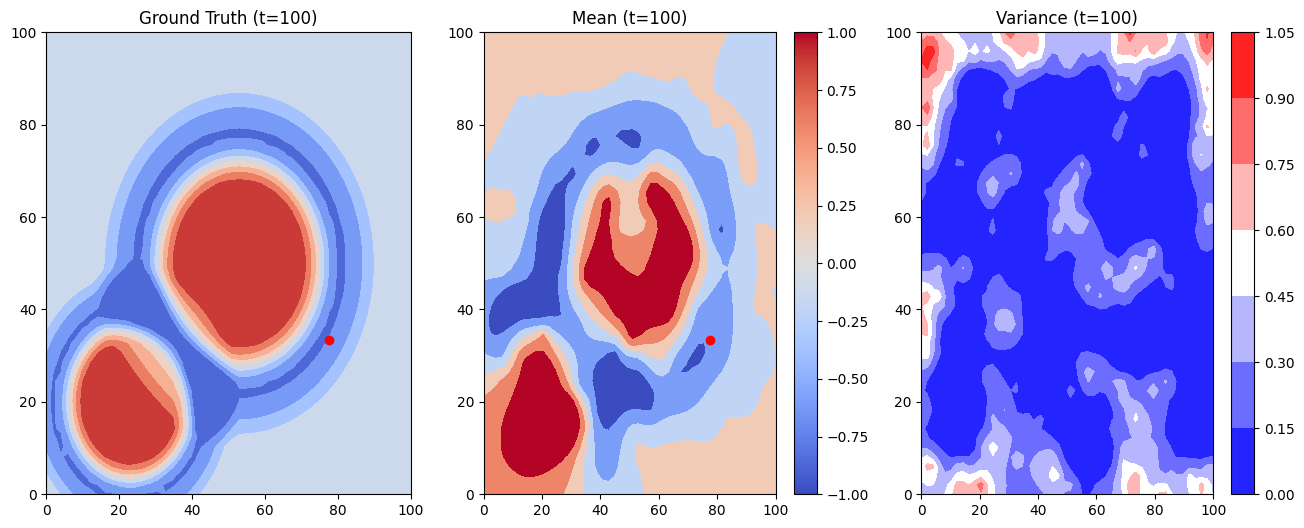

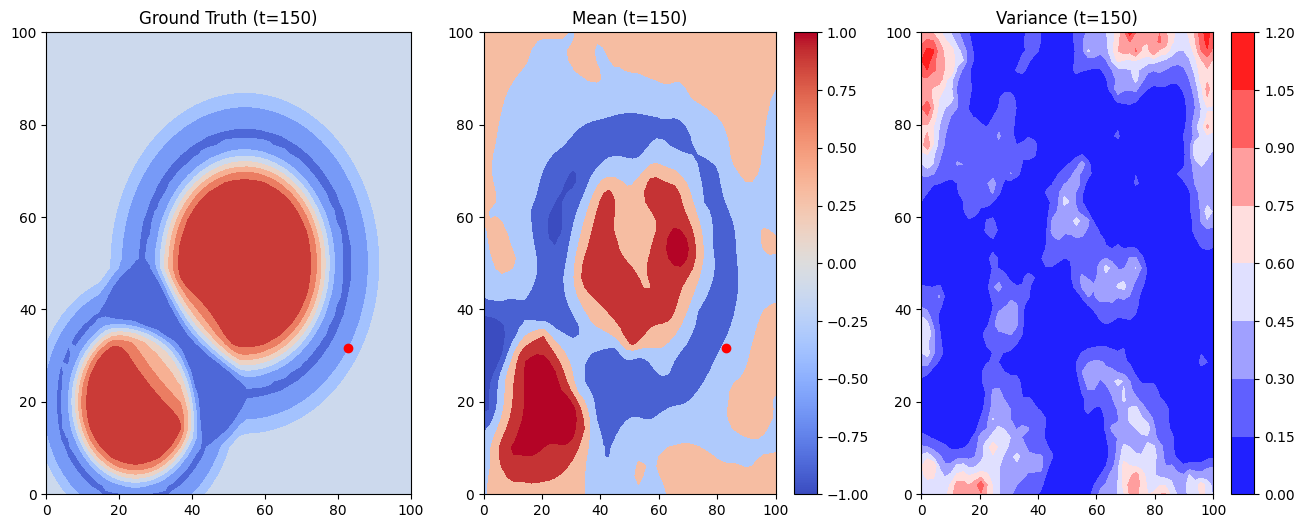

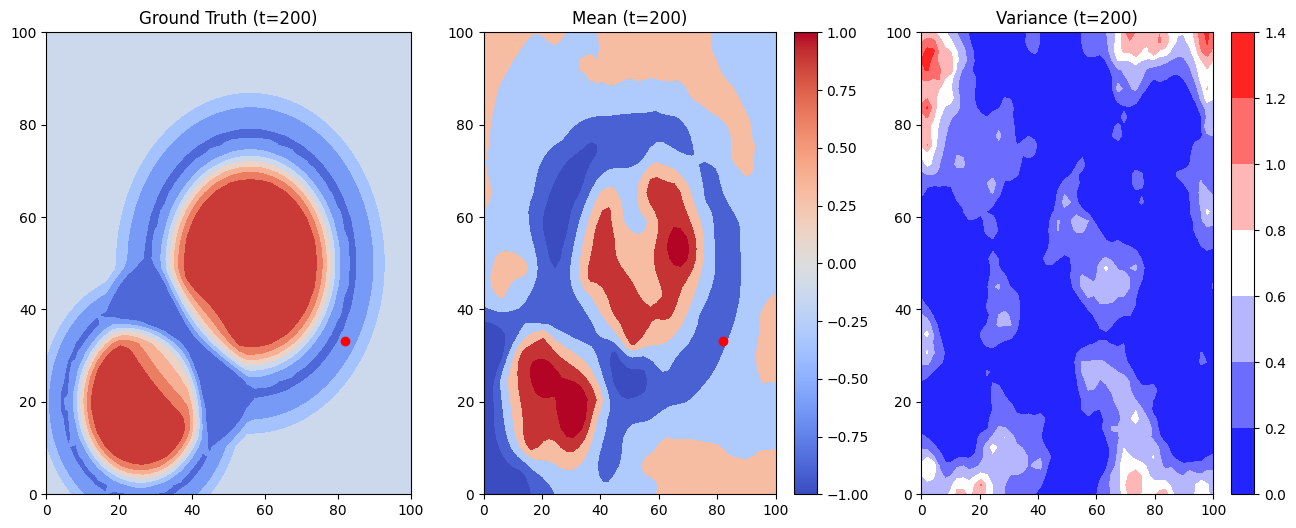

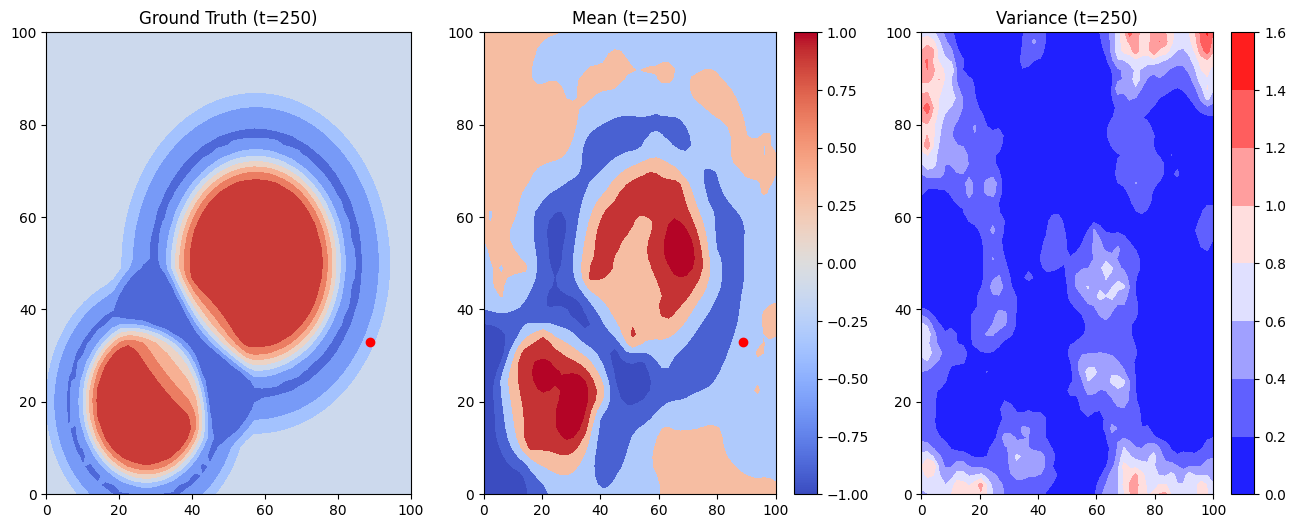

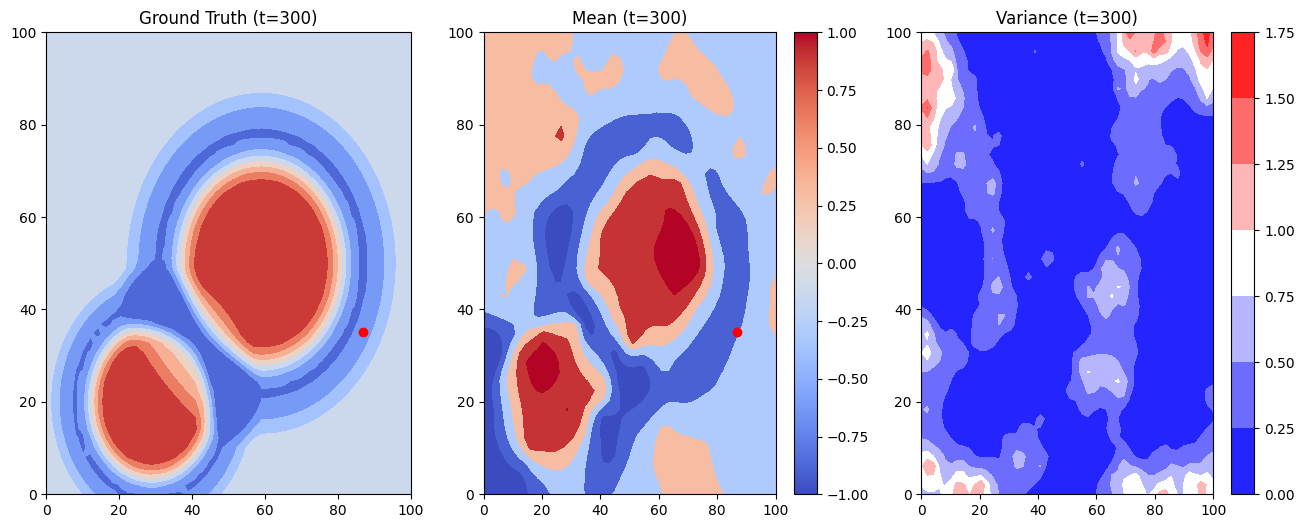

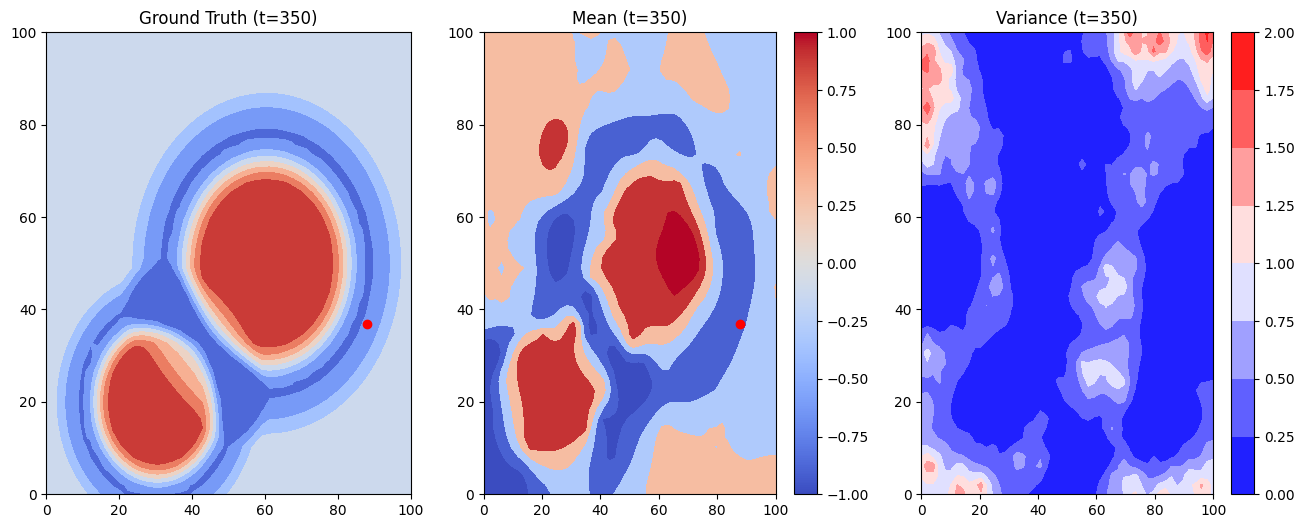

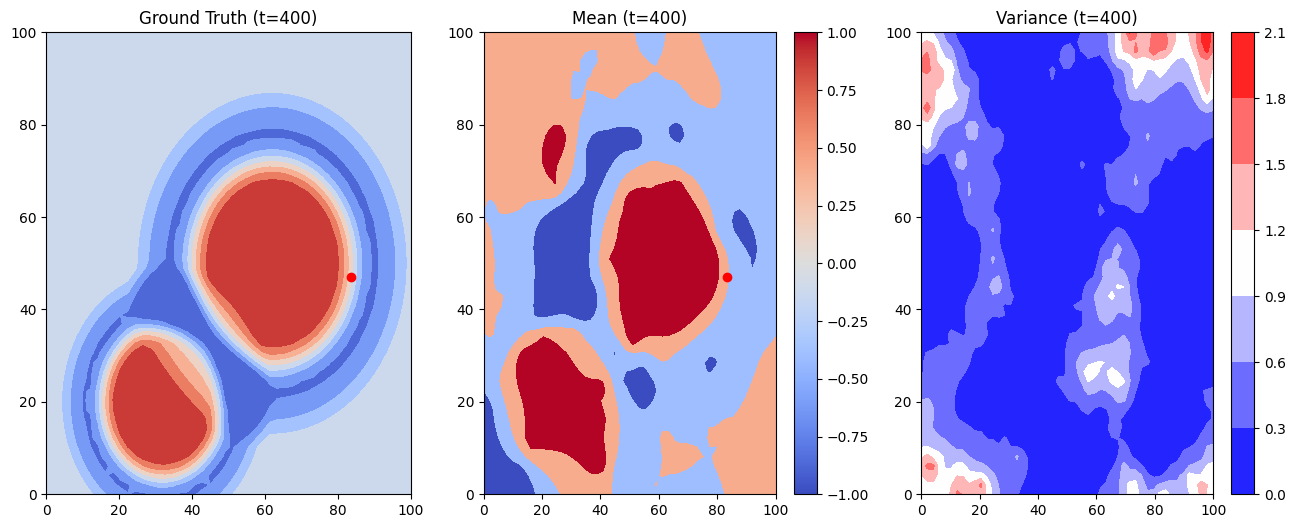

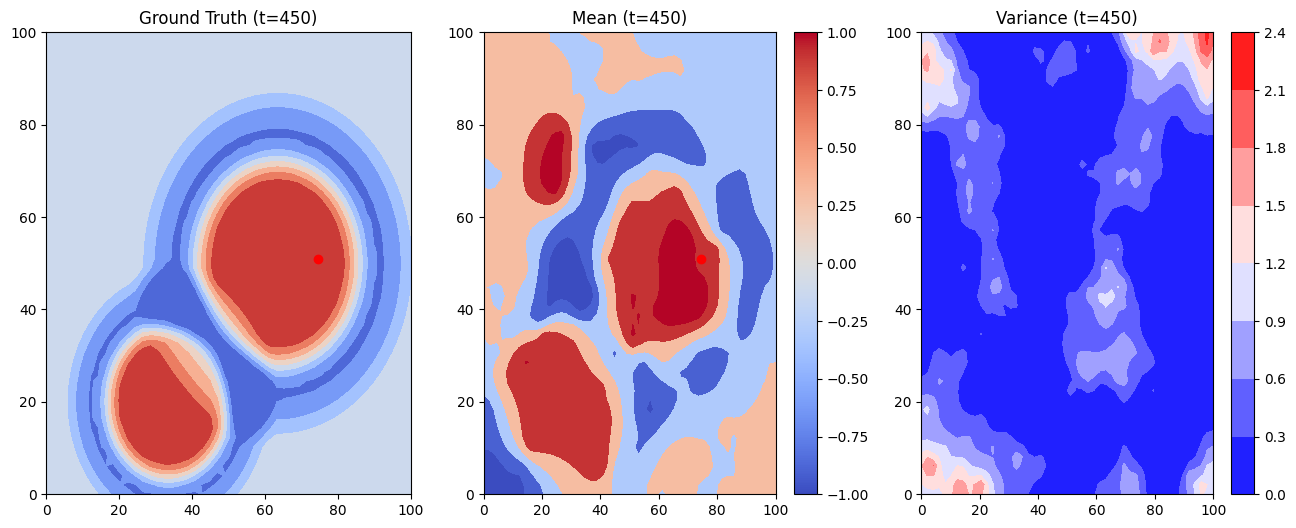

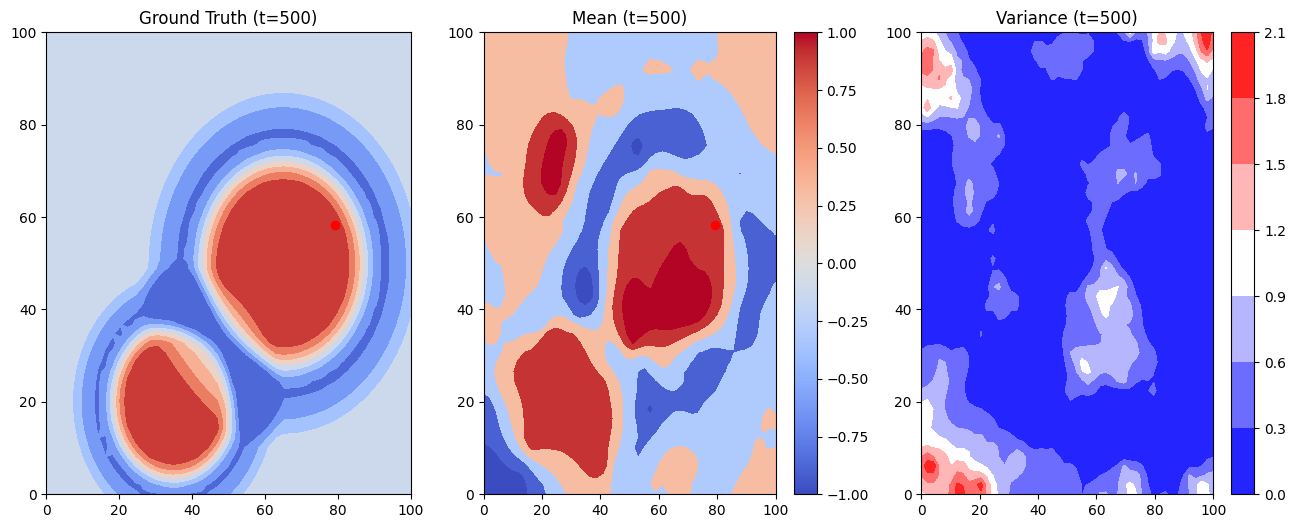

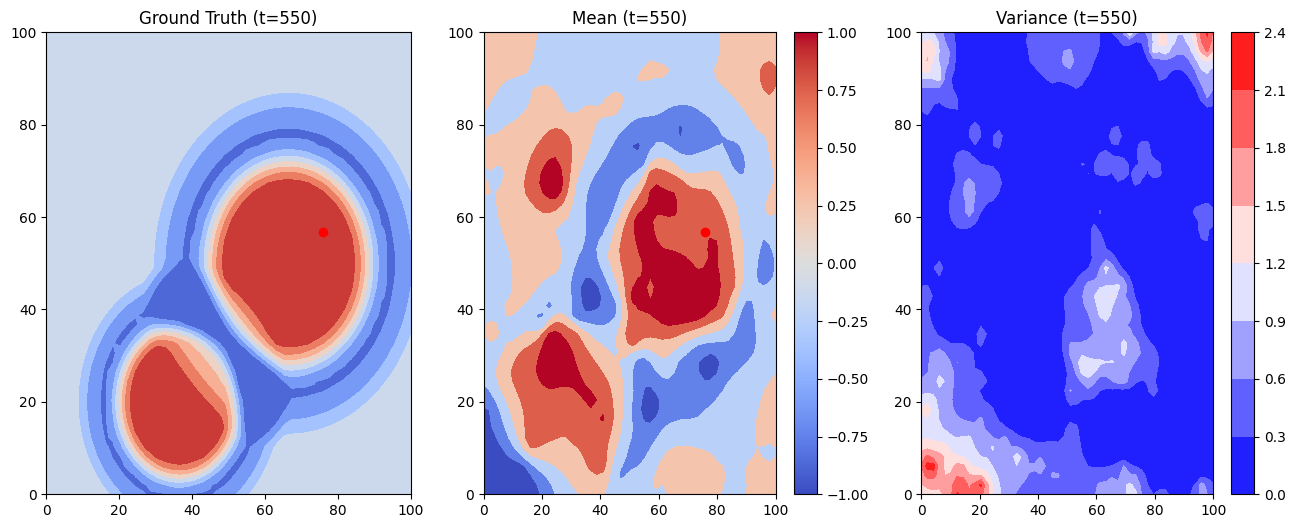

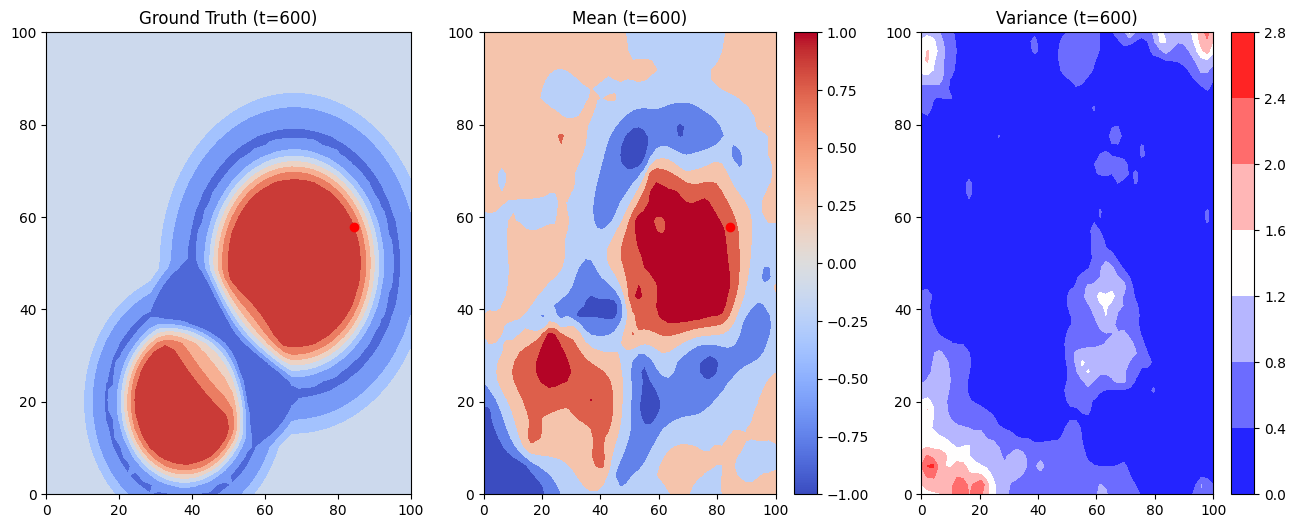

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
import scipy
import matplotlib.colors as mcolors

length_scale_2 = 10
sigma_kernel = 1e-2
sigma_s = sigma_kernel
# Kernel
sigma_n = 0
length_scale = 20
seed = 0

E = 300
l = 300

wind_direction_clouds = np.array([1,0])

kernel = ConstantKernel(sigma_n, constant_value_bounds="fixed") + Matern(length_scale, length_scale_bounds=(1e-05, 100.0), nu=0.5)

drones = [DistKP_Agent(position=drone_positions[i], area_size=area_size, kernel=kernel, E = E, seed = 0) for i in range(num_drones)]
# Create a 2D grid for x, y
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)

xv, yv = np.meshgrid(x, y)

# Initial positions of drones (x, y)
XY = np.vstack([xv.ravel(), yv.ravel()]).T
# Calculate the true function values
wind = wind_field_2d(XY, clouds_2d, 0, wind_direction_clouds).reshape(xv.shape)

sample_points = []
sample_points_n = []

alphas = np.zeros((num_drones, E*E))
bhetas = np.zeros((num_drones, E))

def build_matrix(drones):
  max_distance = 200

  adjacency_matrix = np.zeros((num_drones, num_drones))
  matrix = np.eye(num_drones)
  positions = np.array([drone.position for drone in drones])
  # Compute pairwise distances
  distances = np.linalg.norm(positions[:, np.newaxis] - positions, axis=2)
  adjacency_matrix[distances <= max_distance] = 1
  adjacency_matrix[distances == 0] = 0
  matrix = (adjacency_matrix + matrix)
  return matrix

# Build adjacency matrix:
adjacency = build_matrix(drones)

Ps = np.zeros((num_drones, E*E))
thetas = np.zeros((num_drones, E))

for step in range(601):
  # Simulate the drones collecting data and updating the GP
  if step == 0:
    for drone in drones:
        X_new, y_new = drone.collect_data(step)
        sample_points.append(np.array([X_new[0][0], X_new[0][1]]))
        drone.kalman_update(X_new, y_new)
        drone.move()
  elif step % 1 == 0:
    for drone in drones:
        X_new, y_new = drone.collect_data(step)
        drone.kalman_update(X_new, y_new)
        sample_points.append(np.array([X_new[0][0], X_new[0][1]]))
        drone.move()
  else:
    for drone in drones:
        drone.move()

  if step % 50 == 0:
    Z_pred = drones[6].predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    Z_true = wind_field_2d(XY, clouds_2d, step, wind_direction_clouds).reshape(X.shape)
    # Visualize the positions
    plt.figure(figsize=(16, 6))
    plt.subplot(1,3,1)
    plt.contourf(X, Y, Z_true, cmap='coolwarm')
    plt.scatter(drones[6].position[0], drones[6].position[1], c='red', label='Drone')
    plt.title(f'Ground Truth (t={step})')

    ax = plt.subplot(1,3,2)
    norm = mcolors.Normalize(vmin=-1, vmax=1, clip=True)
    contour = plt.contourf(X, Y, Z_pred, cmap='coolwarm', norm = norm, vmin=-1, vmax=1)
    plt.scatter(drones[6].position[0], drones[6].position[1], c='red', label='Drone')
    colormap = plt.cm.get_cmap('coolwarm')
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=-1, vmax=1)
    cbar = plt.colorbar(sm, ax=ax)
    plt.clim(-1, 1)
    plt.title(f'Mean (t={step})')

    plt.subplot(1,3,3)
    v_pred = drones[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    plt.colorbar(contour)
    plt.title(f'Variance (t={step})')
    plt.show()

  adjacency = build_matrix(drones)
  for i in range(num_drones):
    Ps[i,:] = np.linalg.inv(drones[i].P).flatten()
    thetas[i,:] = (np.linalg.inv(drones[i].P) @ drones[i].theta).flatten()

  Ps = adjacency @ Ps
  thetas = adjacency @ thetas

  for i in range(num_drones):
    drones[i].P = np.linalg.inv(Ps[i,:].reshape((E,E))/np.sum(adjacency[i,:]))
    drones[i].theta = np.linalg.inv(Ps[i,:].reshape((E,E))) @ thetas[i,:].reshape((E,1))

### Baseline method

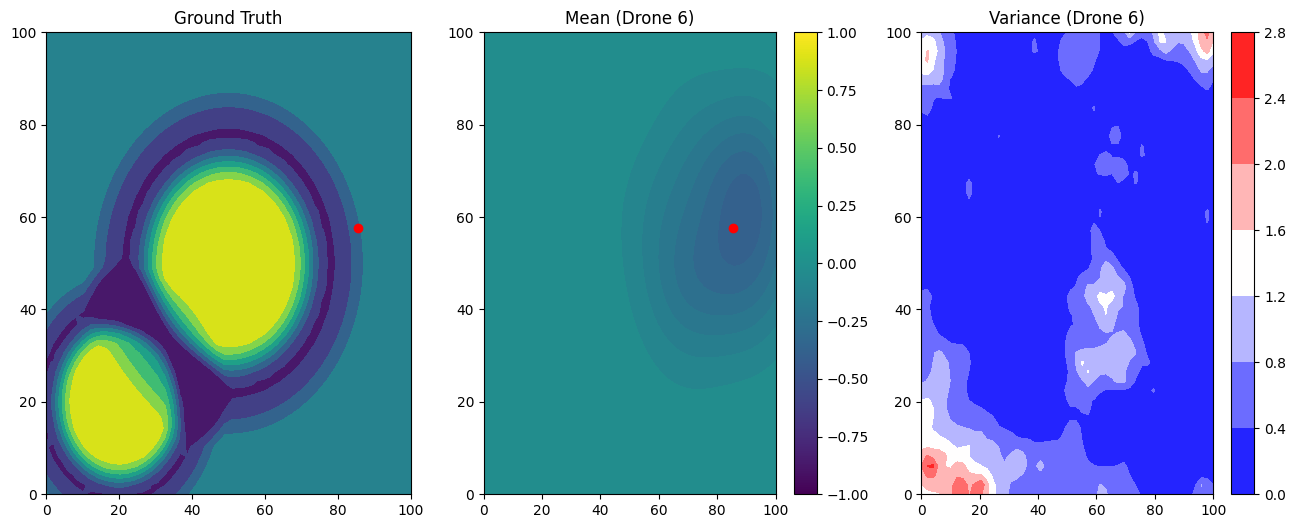

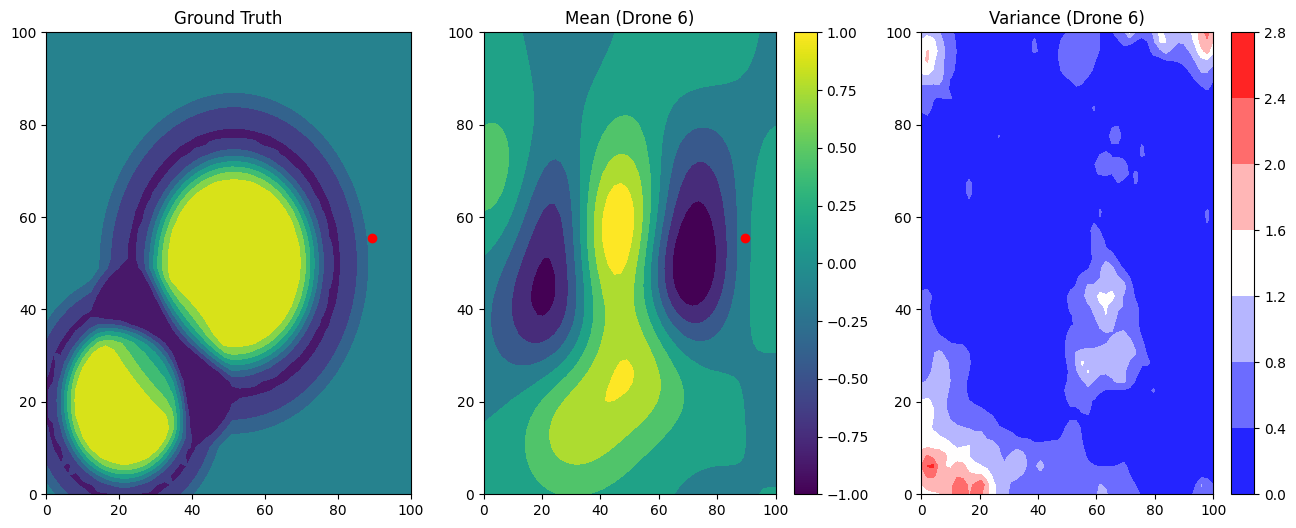

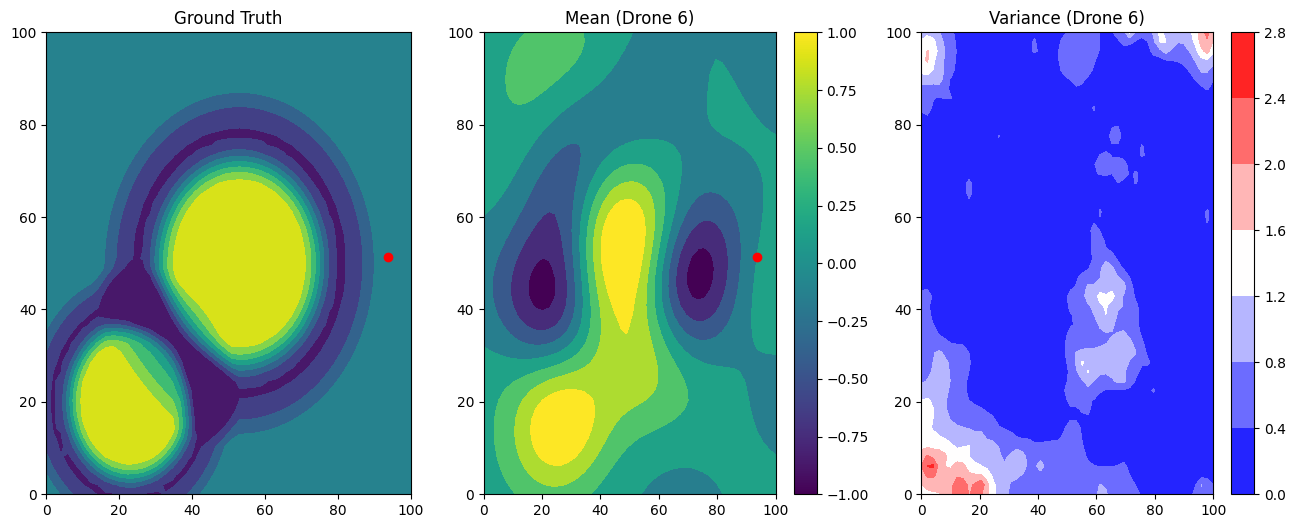

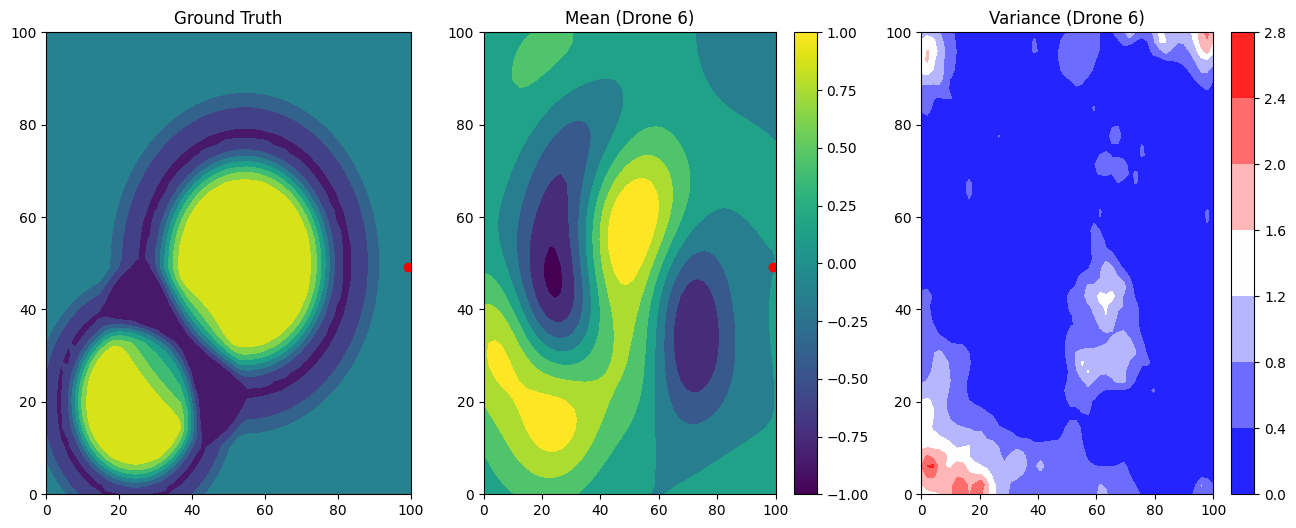

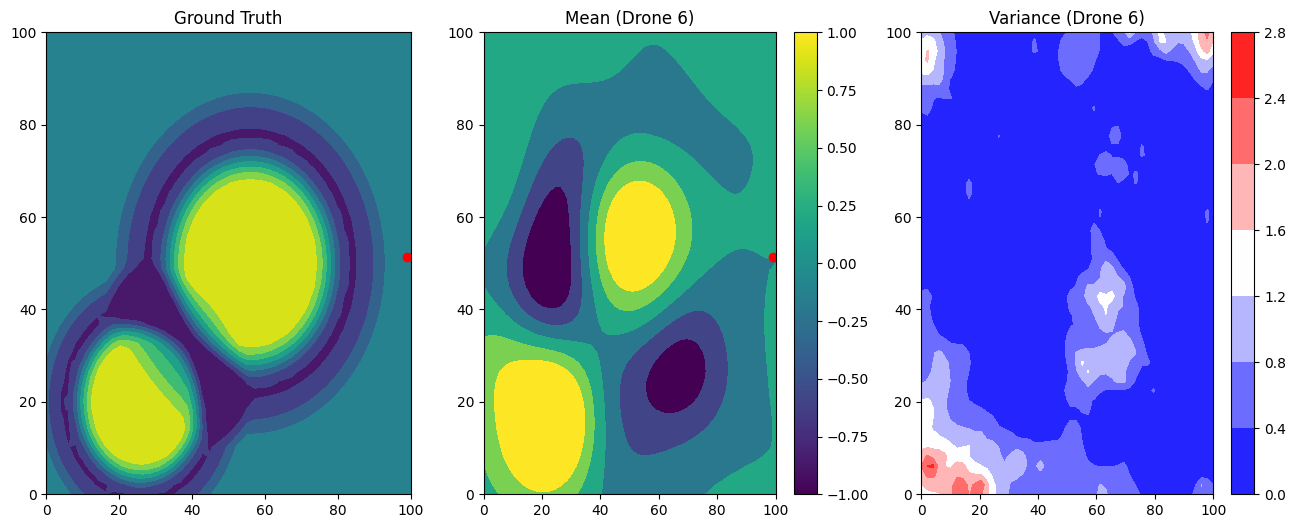

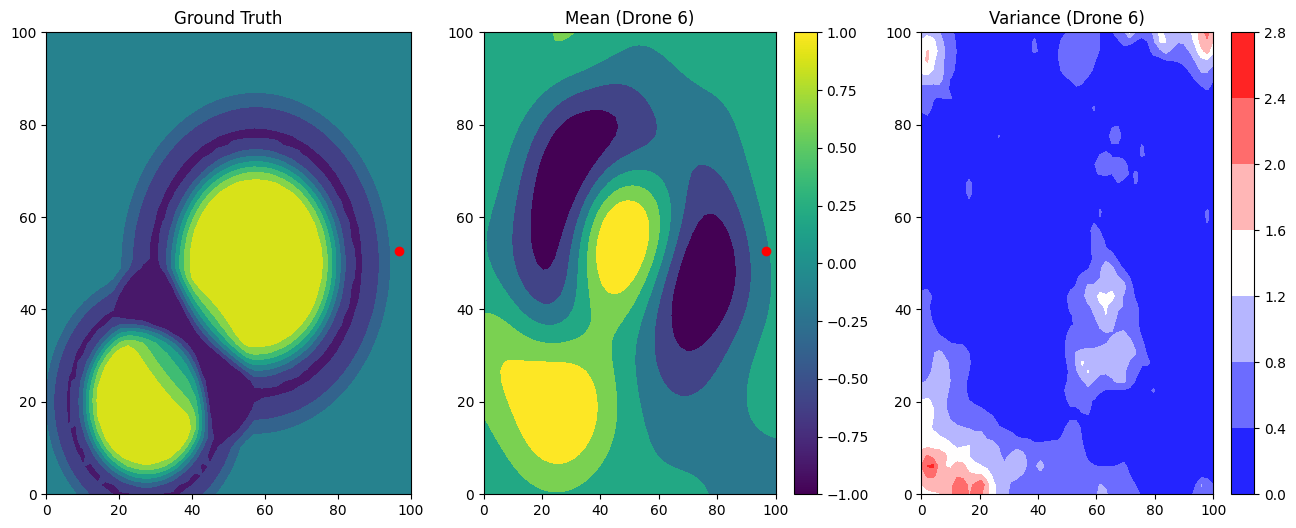

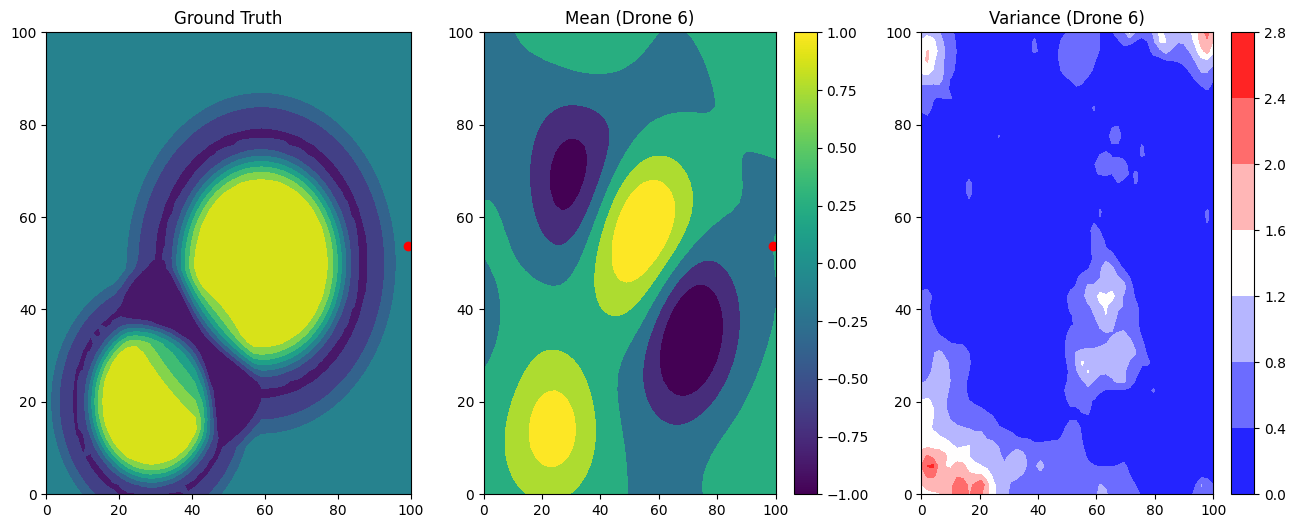

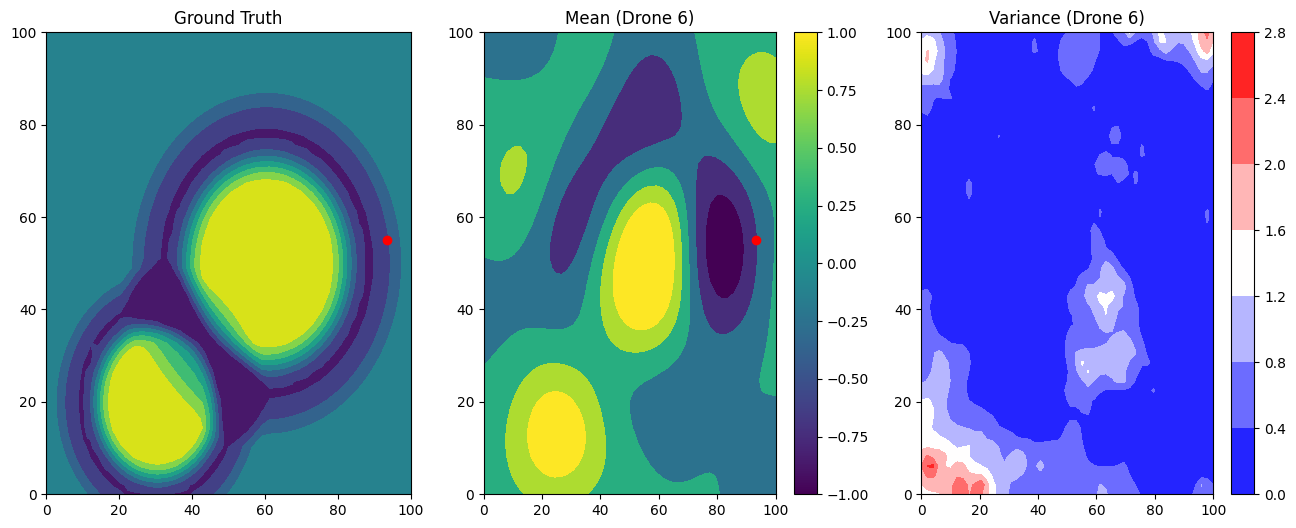

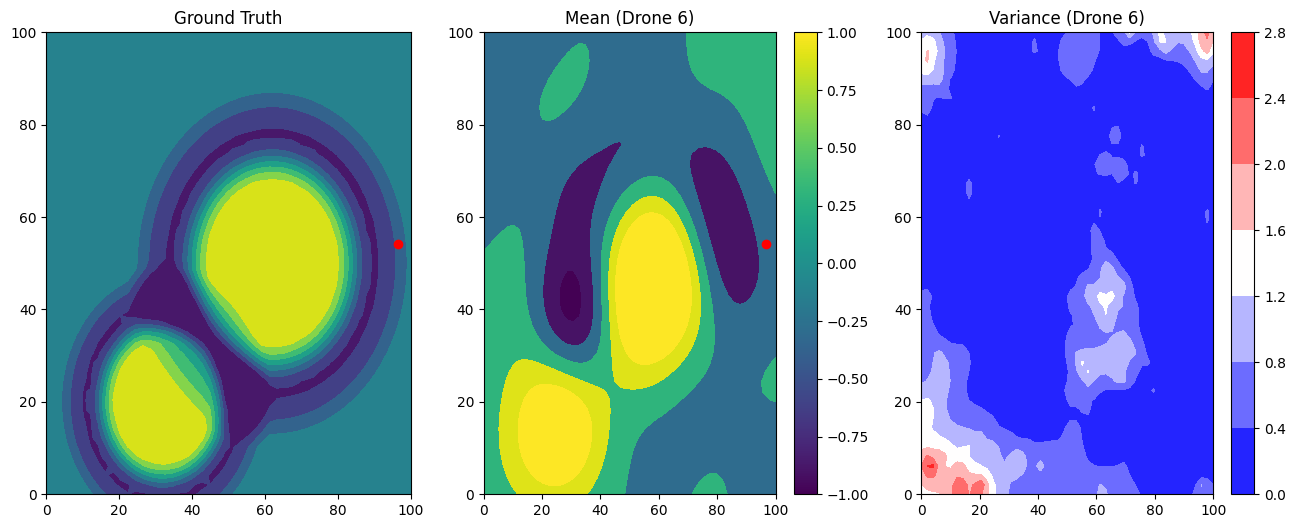

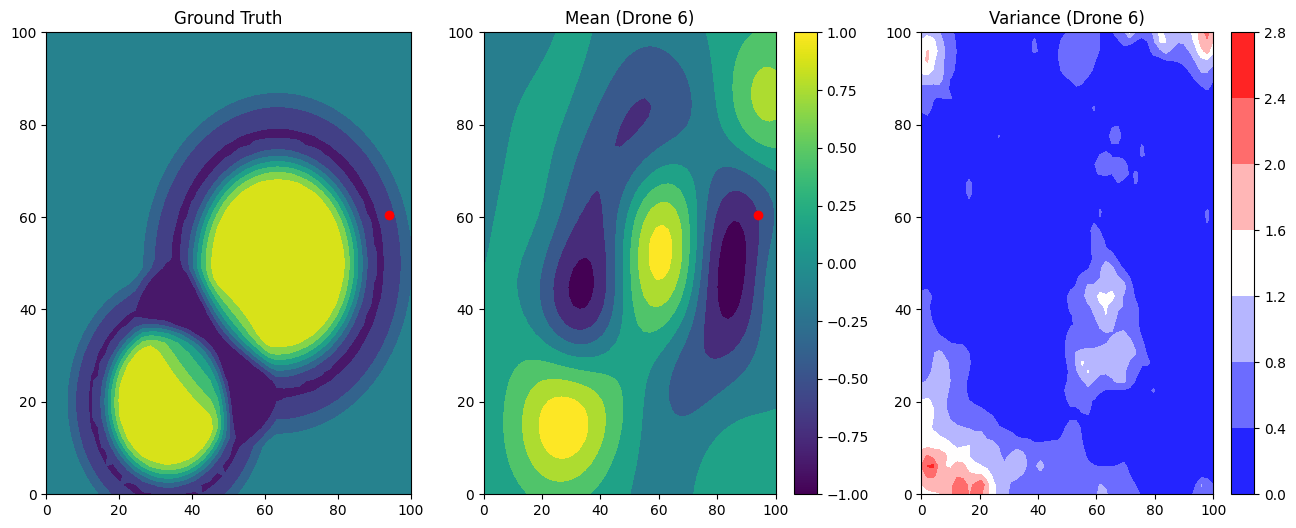

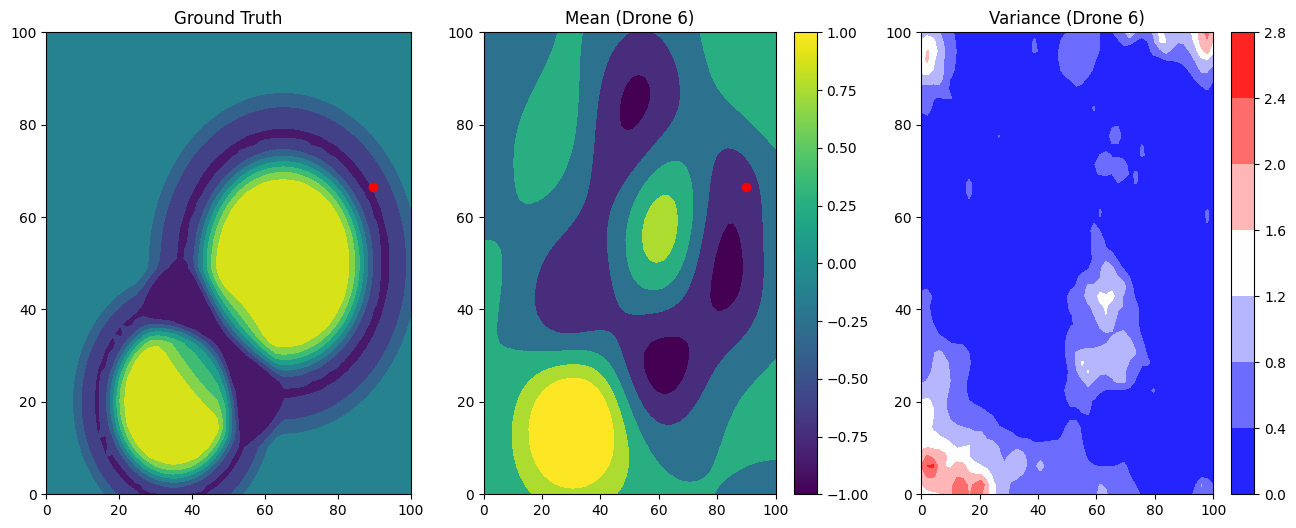

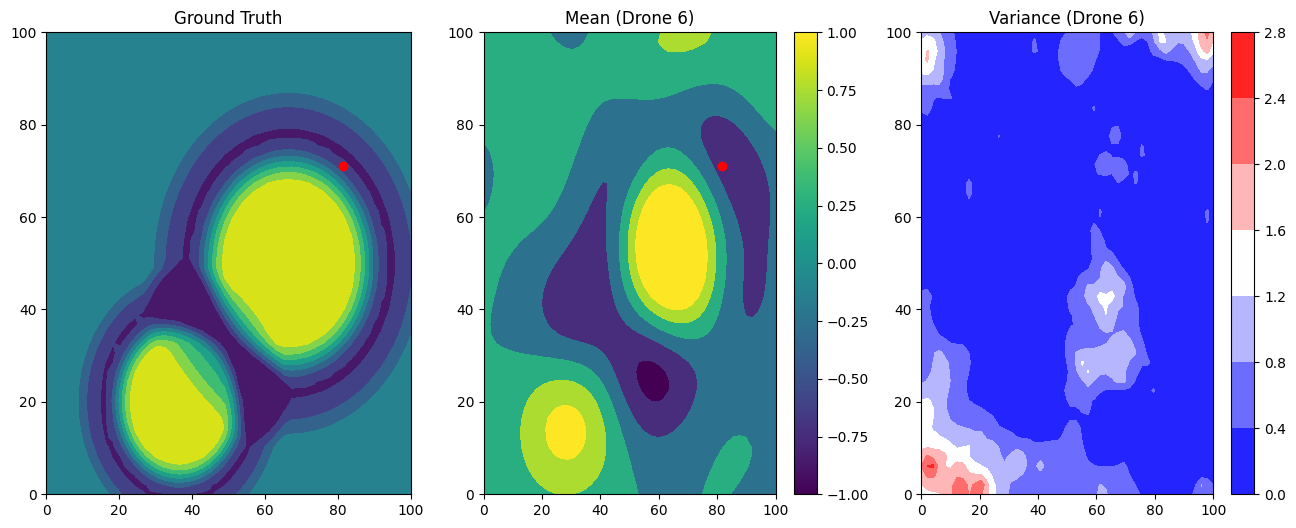

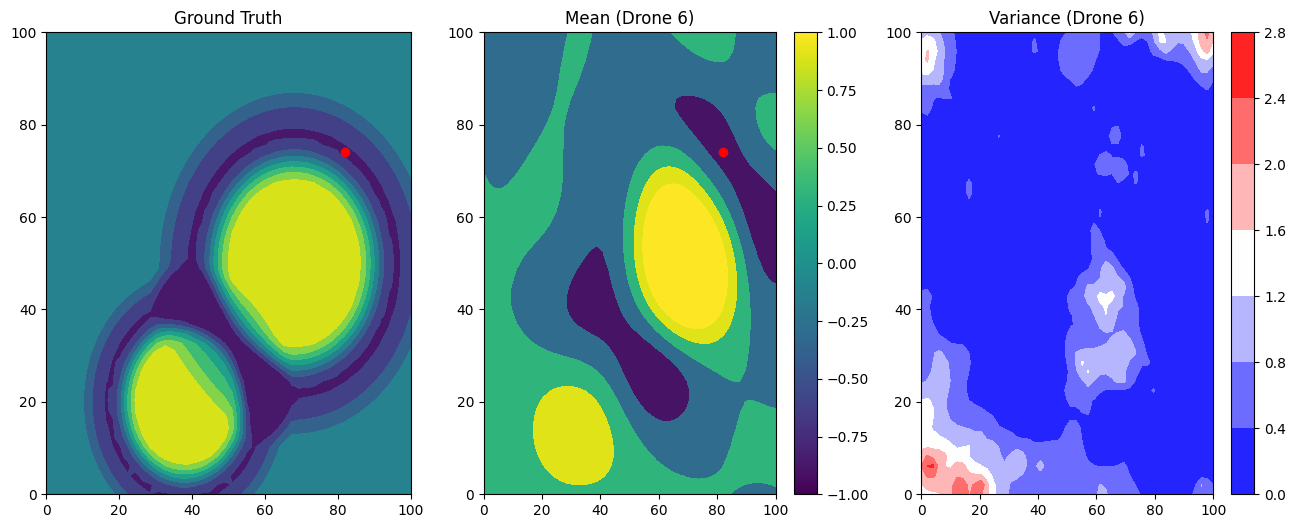

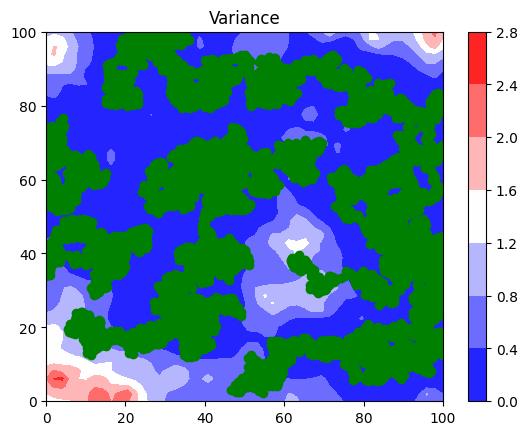

In [6]:
kernel_2 = RBF(length_scale_2, length_scale_bounds="fixed")
drones_noK = [Baseline_Agent(position=drone_positions[i], area_size=area_size, kernel=kernel_2, num_drones = 1, E = E, l = l, sigma= sigma_s, length_scale=length_scale) for i in range(num_drones)]

alphas = np.zeros((num_drones, E*E))
bhetas = np.zeros((num_drones, E))

for step in range(601):
  # Simulate the drones collecting data and updating the GP
  if step == 0:
    for drone in drones_noK:
        X_new, y_new = drone.collect_data(step)
        drone.update_gp()
        drone.move()
  elif step % 5 == 0:
    for drone in drones_noK:
        X_new, y_new = drone.collect_data(step)
        drone.moving_update(X_new, y_new, r = 0.5)
  else:
    for drone in drones_noK:
        drone.move()

  if step % 50 == 0:
    plt.figure(figsize=(16, 6))
    Z_pred = drones_noK[6].predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    Z_true = wind_field_2d(XY, clouds_2d, step, wind_direction_clouds).reshape(X.shape)
    
    plt.subplot(1,3,1)
    plt.contourf(X, Y, Z_true, cmap='viridis')
    plt.scatter(drones_noK[6].position[0], drones_noK[6].position[1], c='red', label='Drone')
    plt.title(f'Ground Truth')

    plt.subplot(1,3,2)
    norm = mcolors.Normalize(vmin=-1, vmax=1, clip=True)
    contour = plt.contourf(X, Y, Z_pred, cmap='viridis', norm = norm, vmin=-1, vmax=1)
    plt.scatter(drones_noK[6].position[0], drones_noK[6].position[1], c='red', label='Drone')
    cbar = plt.colorbar()
    plt.clim(-1, 1)
    plt.title(f'Mean (Drone 6)')
    
    plt.subplot(1,3,3)
    v_pred = drones[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    plt.colorbar(contour)
    plt.title('Variance (Drone 6)')
    
    plt.show()

  if step % 50 == 0:
    adjacency = build_matrix(drones_noK)
    for i in range(num_drones):
      alphas[i,:] = drones_noK[i].alpha.flatten()
      bhetas[i,:] = drones_noK[i].beta.flatten()

    alphas_old = alphas.copy()
    bhetas_old = bhetas.copy()

    alphas = adjacency @ alphas
    bhetas = adjacency @ bhetas
    for i in range(num_drones):
      drones_noK[i].alpha = alphas[i,:].reshape((E,E))
      drones_noK[i].beta = bhetas[i,:].reshape((E,1))


x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
sampled_points = np.vstack(sample_points)
xv, yv = np.meshgrid(x, y)
XY = np.vstack([xv.ravel(), yv.ravel()]).T
v_pred = drones[0].variance(XY)
v_pred = v_pred.reshape(xv.shape)
contour = plt.contourf(xv, yv, v_pred, cmap='bwr')
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c='green', label='Drones')
plt.colorbar(contour)
plt.title('Variance')
plt.show()